# CE4021 Group Project

### Group 2.2

### Student Name: Mark Murnane
### Student ID: 18195326

___

## Team Contributions

The following table outlines the contributions of the team to this Machine Learner.

<table>
    <thead>
        <tr>
            <th/>
            <th scope="col">Mark Murnane</th>
            <th scope="col">Vipul Popat</th>
            <th scope="col">Niall Tierney</th>
            <th scope="col">Chelliah Kanthanathan</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <th scope="row">Training Data</th>
            <td>Sourced Data &<br>Primary Development</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <th scope="row">Pre-processing</th>
            <td>Primary Development</td>
            <td>Code to check for empty values</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <th scope="row">Algorithm Training<br>& Evaluation</th>
            <td>Primary Development</td>
            <td>-</td>
            <td>-</td>
            <td>-</td>
        </tr>
        <tr>
            <th scope="row">Visualisation</th>
            <td>Primary Development</td>
            <td>-</td>
            <td>Plotting the confusion matrix</td>
            <td>-</td>
        </tr>
    </tbody>
</table>    

___

## Problem Description

Given a dataset describing empirical qualities of a wine (e.g. acidity, sugar levels) analyze the data using a Multi-Layer Perceptron Neural Network to build a classifier of the wine's quality.  The quality of the wine is described in the data set as a integer value from 1-10, making it appropriate for classification.


In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn import pipeline
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

___
## Data Set

### Origin

The data set has been sourced from the University of California, Irvine's (UCI) Machine Learning Repository ([link](http://archive.ics.uci.edu/ml/index.php)).  The data was made available in support of a data mining approach for wine quality described in (Cortez _et al._, 2009).  

The data set for red wine was downloaded from [Kaggle](https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009), but can be found in the UCI archive [here](https://archive.ics.uci.edu/ml/datasets/wine+quality).  A combined data set for red and white wine is available from  Paulo Cortez's [website](http://www3.dsi.uminho.pt/pcortez/wine/).

### Data Import

The data set is read from a CSV using the Pandas framework to yield a Pandas data frame.  

In [2]:
# Data Import
wine_source = pd.read_csv('winequality-red.csv', header=0, )

wine_source.info(verbose=False)
print()

wine_source.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Columns: 12 entries, fixed acidity to quality
dtypes: float64(11), int64(1)
memory usage: 150.0 KB



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Vipul's code provides a neat way to identify if there are any missing values in each column

In [3]:
null_counts = wine_source.isnull().sum()
print("Number of null values in each column:\n{}".format(null_counts))

Number of null values in each column:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


As the data set is complete and does not need any gaps to be inferred/replaced, then the feature and target data can be extracted to _numpy_ arrays for use by the _scikit-learn_ models.

The target of the data set is located in the last column of the data frame, while the remaining columns are features of the data set.  Feature and target data can be separated simply by reference to the last column.

In [4]:
wine_data = wine_source.values[:,:-1]
wine_target = wine_source.values[:,-1]

___
## Pre-processing

The data set contains 11 features which combine to provide the output.  For many of the features in the data set, the variance is relatively low (e.g. density which approximate to 1).  A simple way to explore how to tackle the data set is to identify any dominant features.  Equally some features (such as density) will play next to no part in discriminating the results.

The determine if this is the case, and if so what to include/remove, Principal Component Analysis is used to identify the most important components.

The features have different scales, however, often an order of magnitude apart.  To avoid larger numeric variances from dominating the PCA algorithm, the data will be normalised before PCA or model processing.


### Outliers

Box Plots of the data show that for several features there are a large number of outliers.  Scaling the data will help reduce the impact of these outliers on the data.  

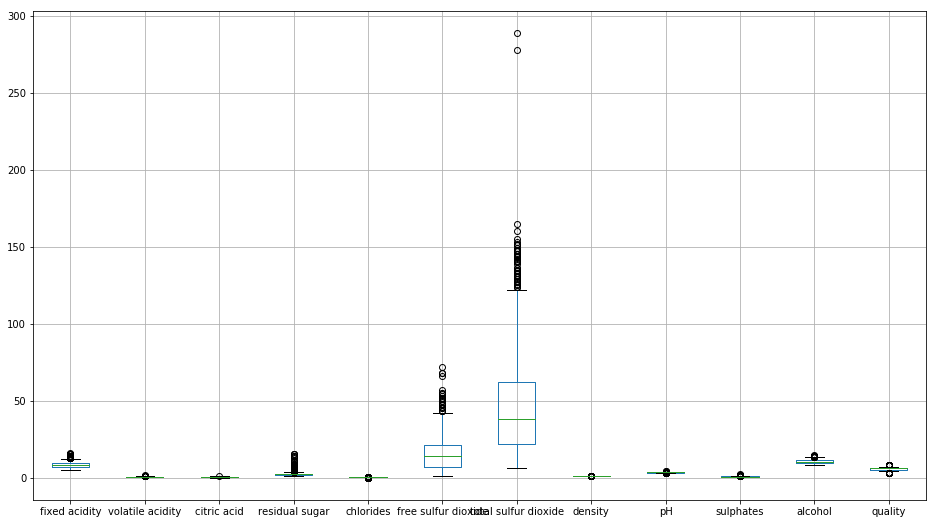

In [5]:
wine_source.boxplot(figsize=(16,9))

### PCA on the full data set


While in many examples the data is split into a test and training sets ahead of PCA, as the sample size is relatively small, a PCA analysis on the full set is performed.  This will give a more comprehensive view of the data set

In [6]:
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

def plot_pca_variance (cumulative_variance_data, variance_data, components = 11, max_percentage = 100, percent_steps = 10):
    # Titles
    plt.title("PCA Components contribution to Data Set Variance")
    plt.xlabel("Principal Components")
    plt.ylabel("Data Set Variance (%)")

    # Set boundaries and assert ticks for each components
    # Increase the x and y limits by a margin so that the graph doesn't abut the boundaries
    plt.xlim(0, components + 1)
    plt.ylim(0, max_percentage + 5)
    plt.xticks(range(0, components + 1))
    plt.yticks(range(0, max_percentage + 5, percent_steps))

    # Grid for ease of reading
    plt.grid(True, linestyle='--')
    
    plt.plot(range(1, components + 1), cumulative_variance_data, label="Cumulative Variance", color="r")
    plt.plot(range(1, components + 1), variance_data, label="Component Variance", color="b", marker="o")
    
    plt.legend()
    plt.show()

#### Outlier Handling

The Box Plots earlier indicated that there were outliers with large absolute values in many of the features sets.  The Examples section of the Scikit-learn site ([link](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html))  and ([Keen, 2017](http://benalexkeen.com/feature-scaling-with-scikit-learn/)) suggests that the `StandardScalar` is sensitive to outliers.

To test the impact of the outliers on the normalisation of the data set, the `StandardScalar` and the `RobustScalar` are compared below.

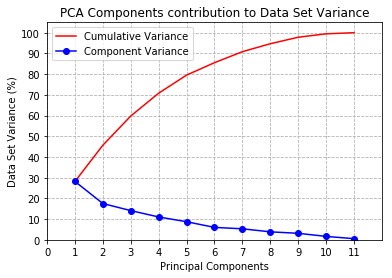

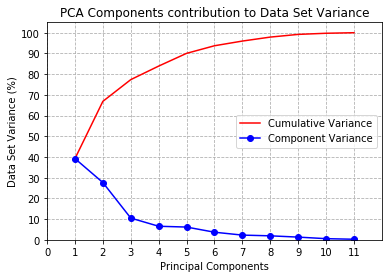

In [7]:
# 1. Normalisation
wine_data_std = preprocessing.scale(wine_data, axis=0)
wine_data_rbst = preprocessing.robust_scale(wine_data, axis=0)

# 2. Do a PCA analysis using Standard scaling
pca_full_std = PCA()
pca_full_std.fit(wine_data_std)

full_variance_ratio = pca_full_std.explained_variance_ratio_*100
full_cumulative_vr = np.cumsum(full_variance_ratio)

plot_pca_variance(full_cumulative_vr, full_variance_ratio)

# 2. Do a PCA analysis using Robust scaling
pca_full_rbst = PCA()
pca_full_rbst.fit(wine_data_rbst)

full_variance_ratio = pca_full_rbst.explained_variance_ratio_*100
full_cumulative_vr = np.cumsum(full_variance_ratio)

plot_pca_variance(full_cumulative_vr, full_variance_ratio)

The results from the `StandardScaler` shows a relatively shallow curve, with 5 components required to give 80% data set coverage and 7 required to break through 90%.  

Using the `RobustScalar` gives a stronger correlation between the principal components, resulting in 2 fewer components required to achieve similar coverage of the data set.

The `RobustScaler` will be use for modelling.

### Pre-processing the Target

While the range of the target values is 0 to 10, the data set actually as a smaller range.

In [8]:
print(wine_source["quality"].min())
print(wine_source["quality"].max())

3
8


Some initial testing of the model using the original target data suggested difficulty classifying the features. (Training score of 63%; Test score of 56%).  

As the vast majority of the target values (> 75%) are grouped around the values 5 and 6, it is difficult for the model to discriminate between some of the target values.  To improve the accuracy (by simplifying the problem) we'll reclassify the quality as either "Poor", "Normal", "Improved".

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C34804E908>]],
      dtype=object)

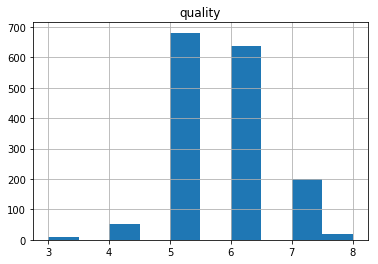

In [9]:
wine_source.hist(column="quality")

In [10]:
def convert_target_quality(target):
    new_target = 0
    
    if target > 6:
        new_target =  2
    elif target > 4:
        new_target = 1
    else:
        new_target = 0
        
    return new_target

new_wine_target = np.array([convert_target_quality(x) for x in wine_target])


### Test and Training Data

The Machine Learner requires both _Training_ and _Test_ data.  As with the analysis above, the split data sets need to be normalised, and specifically the _Test_ data needs to be normalised with the same values as the _Training_ set. 

To simplify the process, a **_Pipeline_** can be used to ensure that the values are correctly applied form one stage to the next without needing any specific coding.

In [11]:
wine_data_train, wine_data_test, wine_target_train, wine_target_test = train_test_split(wine_data, new_wine_target, test_size=0.2, random_state=42)

# Now construct the Pipline for scaling and PCA
pline = pipeline.make_pipeline(preprocessing.RobustScaler(), PCA())
pline.fit(wine_data_train, wine_target_train)

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False))])

To validate the earlier PCA finding we can examine the PCA split on the training data.

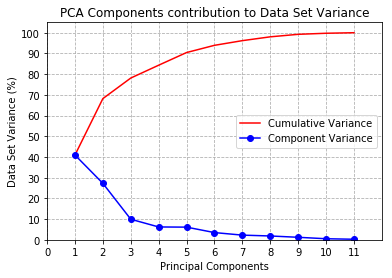

In [12]:
training_pca = pline.named_steps['pca']

training_variance_ratio = training_pca.explained_variance_ratio_*100
training_cumulative_vr = np.cumsum(training_variance_ratio)

plot_pca_variance(training_cumulative_vr, training_variance_ratio)

___
## Algorithm Training


### MLP Classifier

With the data has been normalised the classification model can now be built.

For the model, RELU is used as the activation function for the Neural Network.  The [3Blue1Brown](https://youtu.be/aircAruvnKk?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&t=1024) series indicated strongly that ReLU is preferred over the Sigmoid Function as it tends to train faster, and is a better analogy to biological systems; the neuron is either active or not.  For a data set this size, it may not make of a difference, however.

For the initial attempt we'll use _adam_ as the solver.  The scikit-learn examples include a [Comparison of Stochastic learning strategies](https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py) that show _adam_ quickly converges towards minima across a number of different data sets.

For comparison, we'll also check the L-BFGS solver.  The [scikit-learn Tip for Practial Use section on Neural Nets](https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use) section suggests that L-BFGS preforms better on smaller datasets.

Based on the earlier steps above, for this step we'll create a new pipeline that:

* Normalises the data
* Uses PCA to reduce the number of components to 5
* Executes the MLPClassifier

In [13]:
mlp_net_adam = MLPClassifier(hidden_layer_sizes=(4,4), alpha=1, activation='relu', solver='adam', batch_size=20, shuffle=True, verbose=False, random_state=42)
mlp_net_bfgs = MLPClassifier(hidden_layer_sizes=(4,4), alpha=1, activation='relu', solver='lbfgs', verbose=True, random_state=42)

model_pipe_adam = pipeline.make_pipeline(preprocessing.RobustScaler(), PCA(n_components=5), mlp_net_adam)
model_pipe_adam.fit(wine_data_train, wine_target_train)

model_pipe_bfgs = pipeline.make_pipeline(preprocessing.RobustScaler(), PCA(n_components=5), mlp_net_bfgs)
model_pipe_bfgs.fit(wine_data_train, wine_target_train)

train_score_adam = model_pipe_adam.score(wine_data_train, wine_target_train)
train_score_bfgs = model_pipe_bfgs.score(wine_data_train, wine_target_train)

print(f"Training set score for adam:\t{train_score_adam:.3f}")
print()
print(f"Training set score for L-BFGS:\t{train_score_bfgs:.3f}")

Training set score for adam:	0.826

Training set score for L-BFGS:	0.848


The output above suggests L-BFGS is in fact better for this data set.

### Cross Validation Training

While the above training and test scores seem reasonable a grid search can be used to determine if there are better parameter values.

In [14]:
p_grid = {"alpha": 10.0 ** -np.arange(1, 7)}

mlp_grid_bfgs = GridSearchCV(mlp_net_bfgs, p_grid, cv=5, return_train_score=True)
mlp_grid_bfgs.fit(wine_data_train, wine_target_train)

print(mlp_grid_bfgs.best_score_)
print(mlp_grid_bfgs.best_params_)

0.836591086786552
{'alpha': 0.1}


Updating the models with the results of the Grid Search gives us a new set of predictions.

In [15]:
mlp_net_bfgs = MLPClassifier(hidden_layer_sizes=(4,4), alpha=0.1, activation='relu', solver='lbfgs', verbose=True, random_state=42)

model_pipe_bfgs = pipeline.make_pipeline(preprocessing.RobustScaler(), PCA(n_components=5), mlp_net_bfgs)
model_pipe_bfgs.fit(wine_data_train, wine_target_train)

train_score_bfgs = model_pipe_bfgs.score(wine_data_train, wine_target_train)

print(f"Training set score for L-BFGS:\t{train_score_bfgs:.3f}")

Training set score for L-BFGS:	0.862


### Learning Curve

To determine if we could benefit from additional training data, we can use the learning curve to visualise if there is a benefit to be derived from having a bigger training set.

To simplify the process, the following learning curve code is taken from Scikit-Learn's [examples](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html).  The docstring has been removed for brevity.

In [16]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

<module 'matplotlib.pyplot' from 'D:\\Masters\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

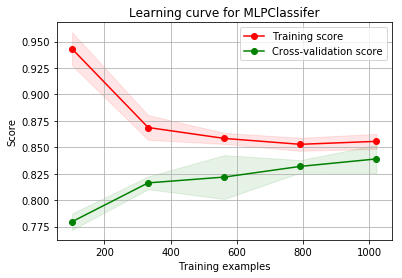

In [17]:
plot_learning_curve(model_pipe_bfgs, "Learning curve for MLPClassifer", wine_data_train, wine_target_train, cv=5)

The implication from the Learning Curve is that the MLPClassifier will not benefit significantly from additional training data.  In fact more training data than is analysed by the `learning_curve` function is provided (1,280 samples vs. 1,022).  

The convergence of the scores reinforces the earlier assessment that the limited variance in key features and the _quality_ target value make this a difficult set to train for ternary classification with a neural network.

___
## Model Results Visualisation

Due to the number of dimensions in the data set (5 after PCA reduciton), it is non-trivial to visualise a decision boundary for the MLPClassifer network.  Another way to visualise the result is to use a _[Confusion Matrix](https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py)_ to get a sense of how accurate the model is.  

As we have 3 classes, we get a 3x3 array of results.  In a perfect model the principal diagonal of the matrix would account for all predicted and test values, with all other elements being 0.

Once the decision was made to use a _Confusion Matrix_, Niall's code (which is very similar to the scikit-learn code) was utilised to visualise the plot.  See further below for commented code showing how Seaborn could achieve a similar (but less polished) diagram.

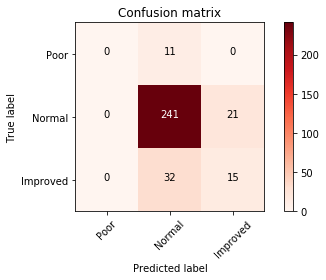

In [18]:
def plot_confusion_matrix(cm, classes,  cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = "d"
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Get some predictions from the Test data set
predictions = mlp_grid_bfgs.predict(wine_data_test)

# Compare the predictions of the model for the Test data set against the actuals
conf_matrix = metrics.confusion_matrix(wine_target_test, predictions)

# Plot the results of the comparison
plot_confusion_matrix(conf_matrix, ["Poor", "Normal", "Improved"], plt.cm.Reds)

In the diagram above we can see that that main diagonal accounts for 259 of 320 tests, of almost 81%.  The matrix shows that the model was unable to correctly predict the "Poor" quality class.  The "Improved" quality class was also incorrectly classified more often than not.

The fact that the data set is dominated by _Normal_ quality wines (values 5 and 6) is making the classification more difficult than might otherwise be the case.  

Using a Seaborn Heatmap was also explored, but the code in Niall's module presented a cleaner diagram with the same result.

In [19]:
#conf_dataframe = pd.DataFrame(conf_matrix, columns= ["Poor", "Normal", "Improved"], index= ["Poor", "Normal", "Improved"])

#plt.title("Confusion Matrix for Wine Classifications by MLPClassifier\n")
#sns.heatmap(conf_dataframe, annot=True, fmt="d", cmap=plt.cm.Reds)

## Reference List


#### Data Model

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.


#### Pre-processing

Scikit-Learn Project (2018) _Compare the effect of different scalers on data with outliers_, available https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html [accessed November 2018]

Keen, Ben Alex (2017) _Feature Scaling with scikit-learn_, available http://benalexkeen.com/feature-scaling-with-scikit-learn/ [access November 2018].


#### Algorithm Training

Sanderson, Grant (2017) _3Blue1Brown Series 3 - Neural Networks_, available https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi, accessed November 2018

Scikit-Learn Project (2018) _Compare Stochastic learning strategies for MLPClassifier_, available https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py [accessed November 2018]

Scikit-Learn Project (2018) _Neural network models (supervised) - Tips on Practical Use_, available https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use [accessed November 2018]

Scikit-Learn Project (2018) _Plotting Learning Curves_, available https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html [accessed November 2018]


#### Model Visualisation

Scikit-Learn Project (2018) _Confusion Matrix_, availabl https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py [accessed November 2018]